# Install and Import dependencies

In [ ]:
!pip install osmnx

In [ ]:
!pip install folium

In [ ]:
import folium
import networkx as nx
import numpy as np
import osmnx as ox
import logging
import random

from abc import abstractmethod
from typing import List, Callable, Tuple

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

from networkx import shortest_path
from osmnx import graph_from_place, plot_graph_route, config

from folium import DivIcon
from folium.plugins import MeasureControl

import time

# Source

## Utils


In [ ]:
def calculate_distance_matrix(graph, coordinates):
    """
    Calcula a matriz de distâncias entre pares de coordenadas em um grafo de rede.

    Parameters:
    - graph (networkx.Graph): O grafo de rede sobre o qual as distâncias serão calculadas.
    - coordinates (list): Uma lista de coordenadas (tuplas) representando pontos no mapa.

    Returns:
    - distances_matrix (numpy.ndarray): Uma matriz de distâncias normalizadas entre os pares de coordenadas.
    """
    # Obtém o número de coordenadas (pontos no mapa)
    n = len(coordinates)

    # Inicializa a matriz de distâncias com valores vazios
    distances_matrix = np.empty((n, n))

    # Loop para calcular as distâncias entre todos os pares de coordenadas
    for i in range(n):
        for j in range(n):
            # Encontra o nó mais próximo no grafo para a coordenada de origem
            source_node = ox.nearest_nodes(graph, coordinates[i][0], coordinates[i][1])
            # Encontra o nó mais próximo no grafo para a coordenada de destino
            target_node = ox.nearest_nodes(graph, coordinates[j][0], coordinates[j][1])
            # Calcula o comprimento do caminho mais curto entre os nós usando o grafo
            distance = nx.shortest_path_length(G=graph, source=source_node, target=target_node, weight='length')
            # Armazena a distância normalizada na matriz de distâncias
            distances_matrix[i][j] = distance / 1000

    # Retorna a matriz de distâncias calculada
    return distances_matrix


In [ ]:
# NEW
def create_map_ref(graph, path, dic):
    """
    Creates an interactive map using the Folium library, displaying a route and numbered markers for specific locations.

    Parameters:
    - graph (networkx.Graph): The network graph used to plot the route.
    - path (list): List of nodes representing the route in the graph.
    - dic (dict): Dictionary containing locations as keys and coordinates as values.

    Returns:
    - route_map (folium.Map): Folium map object displaying the route and markers.
    """

    # Create an initial map with the route highlighted
    route_map = ox.plot_route_folium(graph, path, tiles="OpenStreetMap", zoom_start=12)

    num = 1  # Instead of using enumerate, initialize a variable to track the number

    # Loop through the locations and coordinates in the dictionary
    for loc, coord in dic.items():
        # Add a marker with a tooltip for each location
        folium.Marker(
            coord,
            tooltip=f"{loc}"
        ).add_to(route_map)

        # Add a custom marker with a numbered label
        folium.map.Marker(
            coord,
            icon=DivIcon(
                icon_size=(250, 36),
                icon_anchor=(0, 0),
                html=f'<div style="font-size: 15pt">' + f"{num} - {loc}" + '</div>',
            )
        ).add_to(route_map)

        num += 1  # Increment the number for the next marker

    return route_map

In [ ]:
def calculate_full_path(graph, route, coordinates):
    """
    Calculates the full path and distances between consecutive coordinates along a given route in a network graph.

    Parameters:
    - graph (networkx.Graph): The network graph used for path calculation.
    - route (list): List of node indices representing the sequence of nodes in the route.
    - coordinates (list): List of coordinates (tuples) representing points on the map.

    Returns:
    - full_path (list): List of nodes representing the complete path along the given route.
    - distances (list): List of distances between consecutive coordinates along the route (in kilometers).
    """

    full_path = []  # Initialize an empty list to store the complete path
    distances = []  # Initialize an empty list to store distances

    # Loop through the coordinates to calculate paths and distances
    for i in range(0, len(coordinates) - 1):
        from_index = route[i]
        end_index = route[i + 1]

        # Find the nearest nodes in the graph for the source and target coordinates
        source_node = ox.nearest_nodes(graph, coordinates[from_index][0], coordinates[from_index][1])
        target_node = ox.nearest_nodes(graph, coordinates[end_index][0], coordinates[end_index][1])

        # Calculate the shortest path between the source and target nodes
        path = nx.shortest_path(graph, source_node, target_node, weight='length')

        # Calculate the distance of the path (in kilometers)
        distance = nx.shortest_path_length(G=graph, source=source_node, target=target_node,
                                           weight='length') / 1000
        distances.append(distance)

        # Append the path (excluding the first node) to the full_path list
        full_path += path[1:]

    return full_path, distances


In [ ]:
def create_init_route(start, end, n):
    """
    Creates an initial route consisting of nodes from 0 to n-1, with the specified start and end nodes.

    Parameters:
    - start (int): The starting node index.
    - end (int): The ending node index.
    - n (int): The total number of nodes in the route.

    Returns:
    - route (list): Initial route list with start and end nodes included.
    """

    # Create a route list containing nodes from 0 to n-1
    route = [k for k in range(n)]

    # Remove the start node from the route if it exists
    if start in route:
        route.remove(start)

    # Remove the end node from the route if it exists
    if end in route:
        route.remove(end)

    # Add the start node at the beginning and the end node at the end of the route
    route = [start] + route + [end]

    return route

## Simulated Annealing


In [ ]:
logger = logging.getLogger(__name__)
class SAModel:
    """
    Use case specific SA model that needs to be inherited by user of SARouteOptimizer.

    Contains methods used in SARouteOptimizer to
    - calculate cost for route
    - mutate route
    - calculate temperature
    - calculate probability from cost change and temperature
    """

    @staticmethod
    def schedule(t: int, max_temperature: float = 1.0, decay_constant: float = 0.005) -> float:
        """
        Calculate current temperature from iteration round t.
        """
        return max_temperature * np.exp(-decay_constant * t)

    @staticmethod
    def probability(delta_cost: float, temperature: float, k: float = 1) -> float:
        """
        Calculate acceptance probability for mutated route, based on cost change (vs. current solution) and temperature.
        """
        if delta_cost < 0:
            return 1
        else:
            return np.exp(-delta_cost / (k * temperature))

    def mutate(self, input_route: List[int], mutation_probability: float = 0.2) -> List[int]:
        """
        Mutate (modify) given route. This mutated route will be solution candidate that will be accepted or not, based
        on calculated probability.
        """
        route = input_route.copy()
        for k in range(len(route)):
            if random.random() < mutation_probability:
                self._swap(route)

        # Make sure that at least one change is made to input route
        if route == input_route:
            self._swap(route)

        return route

    def _swap(self, route):
        """
        Swap two random elements in the route to create a mutation.
        """
        i, j = random.sample([k + 1 for k in range(len(route) - 2)], 2)
        value_i = route[i]
        value_j = route[j]
        route[i] = value_j
        route[j] = value_i


class SARouteOptimizer:
    """
    Simulated annealing route optimizer. With the given model and termination criteria, finds the optimal route that
    minimizes the cost function defined by the model.
    """

    def __init__(self,
                 model: SAModel,
                 max_iter: int = 10000,
                 max_iter_without_improvement: int = 2000,
                 min_temperature: float = 1e-12,
                 cost_threshold: float = -np.inf,
                 ):

        self.model = model
        self.max_iter = max_iter
        self.max_iter_without_improvement = max_iter_without_improvement
        self.min_temperature = min_temperature
        self.cost_threshold = cost_threshold

        self.temperatures = []
        self.costs = []
        self.probabilities = []
        self.delta_costs = []
        self.is_accepted = []

    def run(self, init_route: List[int]) -> Tuple[List[int], float]:
        """
        Find optimal route.

        :param init_route: Init guess for route.
        :return: optimal route, route cost
        """

        current_route = init_route.copy()
        best_route = current_route.copy()

        current_cost = self.model.cost(current_route)
        best_cost = self.model.cost(best_route)

        probability, delta_cost = 1, 0
        is_accepted = True
        no_improvement_counter = 0

        for t in range(self.max_iter):

            no_improvement_counter += 1
            temperature = self.model.schedule(t)

            if temperature < self.min_temperature:
                logger.info("Minimum temperature reached. Return solution")
                return best_route, best_cost

            self.temperatures.append(temperature)
            self.costs.append(current_cost)
            self.probabilities.append(probability)
            self.delta_costs.append(delta_cost)
            self.is_accepted.append(is_accepted)

            mutated_route = self.model.mutate(current_route.copy())
            mutated_route_cost = self.model.cost(mutated_route)
            logger.debug(f"Mutated route: {mutated_route}; cost {mutated_route_cost}")
            delta_cost = mutated_route_cost - current_cost

            is_accepted = False
            probability = self.model.probability(delta_cost, temperature)
            if probability >= random.uniform(0.0, 1.0):
                is_accepted = True
                current_route = mutated_route.copy()
                current_cost = mutated_route_cost
                if current_cost < best_cost:
                    best_route = current_route.copy()
                    best_cost = current_cost
                    logger.info(f"Found better solution; round {t}; cost {best_cost}")
                    no_improvement_counter = 0
                    if best_cost < self.cost_threshold:
                        logger.info("Cost reached required threshold value. Return solution.")
                        return best_route, best_cost

            logger.debug(f"Round {t}: temperature {temperature}; cost {current_cost}")

            if no_improvement_counter > self.max_iter_without_improvement:
                logger.info("Max iteration number without improvement reached. Return solution.")
                return best_route, best_cost

        logger.info("Max iteration number reached. Return solution.")
        return best_route, best_cost

    def plot_solution(self):
        """
        Plot the optimization process, showing cost and temperature over iterations, as well as the probability plot.
        """
        plt.figure(1)

        ax1 = plt.subplot(1, 2, 1)

        color = 'tab:blue'
        ax1.plot(self.costs, color=color)
        ax1.set_ylabel('Cost', color=color)

        color = 'tab:red'
        ax2 = ax1.twinx()
        ax2.plot(self.temperatures, color=color)
        ax2.set_ylabel('Temperature', color=color)

        ax1.set_xlabel("Iteration")
        plt.title("Cost & temperature")

        plt.subplot(1, 2, 2)
        sc = plt.scatter(self.temperatures,
                         self.delta_costs,
                         c=np.array(self.probabilities) + 0.001,
                         norm=colors.LogNorm(),
                         edgecolors="k",
                         cmap=LinearSegmentedColormap.from_list("MyCmapName", ["b", "r"]))
        plt.colorbar(sc)
        plt.gca().invert_xaxis()
        plt.plot(np.array(self.temperatures)[self.is_accepted],
                 np.array(self.delta_costs)[self.is_accepted],
                 "kx",
                 markersize=3)

        plt.xlabel("Temperature")
        plt.ylabel("Cost change")
        plt.title("Probability")

        plt.tight_layout()
        plt.show()

In [ ]:
class Model(SAModel):
    """
    Custom model class that inherits from SAModel. It defines a cost function based on a given cost_matrix.
    """

    def __init__(self, cost_matrix):
        """
        Initializes the Model with a cost matrix.

        :param cost_matrix: A 2D matrix representing the costs between different nodes.
        """
        super().__init__()  # Call the constructor of the parent class
        self.cost_matrix = cost_matrix

    def cost(self, route):
        """
        Calculates the cost of the given route based on the cost matrix.

        :param route: List of node indices representing the route.
        :return: Total cost of the route.
        """
        cost = 0
        for i in range(len(route) - 1):
            from_index = route[i]
            to_index = route[i + 1]
            cost += self.cost_matrix[from_index][to_index]
        return cost


# Run

## Gastronomica

In [138]:
# Dictionary representing the coordinates of various locations
LOCATIONS = {
    "Camarões" : (-5.87244152178619, -35.18008155202867),
    "La Brasserie de La Mer": (-5.870958665356251, -35.181186031276866),
    "Marechal": (-5.793410203944437, -35.19830383556667),
    "Manary Gastronomia & Arte": (-5.873834285326771, -35.17713633618638),
    "Lotus": (-5.86905815229999, -35.18052571370415),
    "Nau Frutos do Mar": (-5.8462451752719, -35.19958121192399)
}

# Flag indicating whether to use saved distances (True) or recalculate distances (False)
USE_SAVED_DISTANCES = False

# Names of the start and end locations for route optimization
START_LOCATION = "Camarões"
END_LOCATION = "Camarões"


In [139]:
# Create a road network graph for the city of Natal, Rio Grande do Norte, Brazil
graph = graph_from_place('Natal, Rio Grande do Norte, Brazil', network_type='drive')

In [140]:
# Configure OSMnx settings to disable console logging, enable caching, and specify the cache folder
config(log_console=False, use_cache=True, cache_folder='./cache')
# Configure the root logging level to INFO
logging.basicConfig(level=logging.INFO)

<ipython-input-140-b779ef67c0ae>:2: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  config(log_console=False, use_cache=True, cache_folder='./cache')


In [141]:
loc_names, coordinates = [], [] # Extract location names and coordinates from the LOCATIONS dictionary

for name, coord in LOCATIONS.items():
    loc_names.append(name)
    # Flip the coordinates (latitude, longitude) to (longitude, latitude)
    coordinates.append((coord[1], coord[0]))

In [142]:
print(loc_names)

['Camarões', 'La Brasserie de La Mer', 'Marechal', 'Manary Gastronomia & Arte', 'Lotus', 'Nau Frutos do Mar']


In [143]:
print(coordinates)

[(-35.18008155202867, -5.87244152178619), (-35.181186031276866, -5.870958665356251), (-35.19830383556667, -5.793410203944437), (-35.17713633618638, -5.873834285326771), (-35.18052571370415, -5.86905815229999), (-35.19958121192399, -5.8462451752719)]


In [144]:
# Check if saved distances should be used
distances_matrix = None

if USE_SAVED_DISTANCES:
    # Attempt to load distances from the file
    print("Loading distances from file")
    try:
        distances_matrix = np.loadtxt("distances.txt")
    except OSError:
        # If loading fails, revert to calculating distances
        USE_SAVED_DISTANCES = False
        print("Could not find distances.txt file.")

# Calculate distances if not using saved distances or if loading failed
if not USE_SAVED_DISTANCES:
    print("Calculating distances between points")
    distances_matrix = calculate_distance_matrix(graph, coordinates)

    # Save calculated distances to file
    print("Saving distances to file")
    np.savetxt("distances.txt", distances_matrix)

Calculating distances between points
Saving distances to file


In [145]:
# Create a Simulated Annealing Route Optimizer instance
optimizer = SARouteOptimizer(
    model=Model(cost_matrix=distances_matrix),
    max_iter=1000,
    max_iter_without_improvement=300
)

In [146]:
print("Calculating optimal order of locations")
init_route = create_init_route(
    loc_names.index(START_LOCATION),
    loc_names.index(END_LOCATION),
    distances_matrix.shape[0]
)

Calculating optimal order of locations


In [147]:
# Record the start time for measuring optimization duration
start_time = time.time()

# Run the optimizer to find the optimal route and total distance
optimal_route, total_distance = optimizer.run(init_route)

# Record the end time and calculate the duration in milliseconds
end_time = time.time()
duration_ms = 1000 * (end_time - start_time)

# Optimization duration
print(f"Solution took {duration_ms:0.0f} ms")
print(f"Total Distance: {total_distance}")

Solution took 12 ms
Total Distance: 24.131982


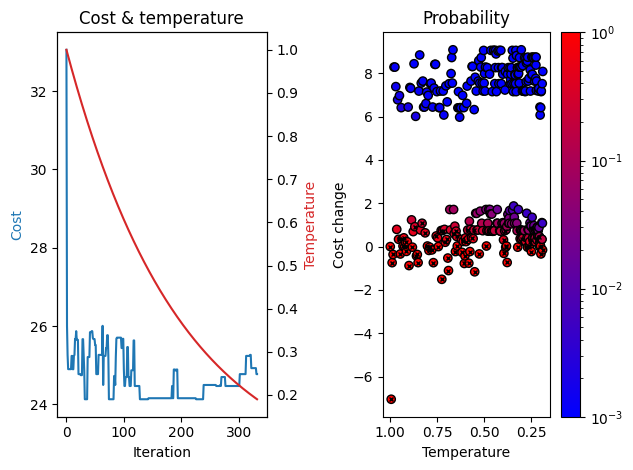

In [ ]:
optimizer.plot_solution()

In [ ]:
print("Creating optimal path")
full_path, distances = calculate_full_path(graph, optimal_route, coordinates)

Creating optimal path


In [ ]:
print("Creating map")
# create_map_ref(graph, path, route, dic, distances):
map = create_map_ref(graph = graph,
                     path=full_path,
                     dic = LOCATIONS)
map

Creating map


<ipython-input-97-4fb30b5931b9>:4: UserWarning: The `folium` module has been deprecated and will be removed in a future release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_map = ox.plot_route_folium(graph, path, tiles="OpenStreetMap", zoom_start=12)


## Rota do Mar

In [148]:
LOCATIONS = {
    "Morro do Careca" : (-5.884077,-35.166928),
    "Via Costeira / Centro de convenções": (-5.863280,-35.180930),
    "Relogio do Sol": (-5.791485,-35.186630),
    "Letreiro - AMO NATAL": (-5.789055134997181, -35.18858085582142),
    "Escadaria Mãe Luiza": (-5.790476897702521, -35.18804693206095),
    "Centro Municipal de Artesanato da Praia do Meio": (-5.782210284329115, -35.19269319583894),
    "Forte dos Reis Magos": (-5.756149347171703, -35.19498948374049)
}

USE_SAVED_DISTANCES = False

START_LOCATION = "Via Costeira / Centro de convenções"
END_LOCATION = "Via Costeira / Centro de convenções"


In [170]:
graph = graph_from_place('Natal, Rio Grande do Norte, Brazil', network_type='drive')

In [150]:
config(log_console=False, use_cache=True, cache_folder='./cache')
logging.basicConfig(level=logging.INFO)

<ipython-input-150-8036529aab0c>:1: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  config(log_console=False, use_cache=True, cache_folder='./cache')


In [151]:
loc_names, coordinates = [], []
for name, coord in LOCATIONS.items():
    loc_names.append(name)
    #coordinates.append(coord)
    coordinates.append((coord[1], coord[0]))

In [152]:
print(loc_names)

['Morro do Careca', 'Via Costeira / Centro de convenções', 'Relogio do Sol', 'Letreiro - AMO NATAL', 'Escadaria Mãe Luiza', 'Centro Municipal de Artesanato da Praia do Meio', 'Forte dos Reis Magos']


In [153]:
print(coordinates)

[(-35.166928, -5.884077), (-35.18093, -5.86328), (-35.18663, -5.791485), (-35.18858085582142, -5.789055134997181), (-35.18804693206095, -5.790476897702521), (-35.19269319583894, -5.782210284329115), (-35.19498948374049, -5.756149347171703)]


In [154]:
distances_matrix = None
if USE_SAVED_DISTANCES:
    print("Loading distances from file")
    try:
        distances_matrix = np.loadtxt("distances.txt")
    except OSError:
        USE_SAVED_DISTANCES = False
        print("Could not find distances.txt file.")

if not USE_SAVED_DISTANCES:
    print("Calculating distances between points")
    distances_matrix = calculate_distance_matrix(graph, coordinates)
    print("Saving distances to file")
    np.savetxt("distances.txt", distances_matrix)

Calculating distances between points
Saving distances to file


In [155]:
optimizer = SARouteOptimizer(model=Model(cost_matrix=distances_matrix),
                             max_iter=1000,
                             max_iter_without_improvement=300)

In [156]:
print("Calculating optimal order of locations")
init_route = create_init_route(loc_names.index(START_LOCATION),
                               loc_names.index(END_LOCATION),
                               distances_matrix.shape[0])

Calculating optimal order of locations


In [157]:
start_time = time.time()
optimal_route, total_distance = optimizer.run(init_route)
end_time = time.time()


duration_ms = 1000 * (end_time - start_time)
print(f"Solution took {duration_ms:0.0f} ms")
print(f"Total Distance: {total_distance}")

Solution took 11 ms
Total Distance: 32.074872


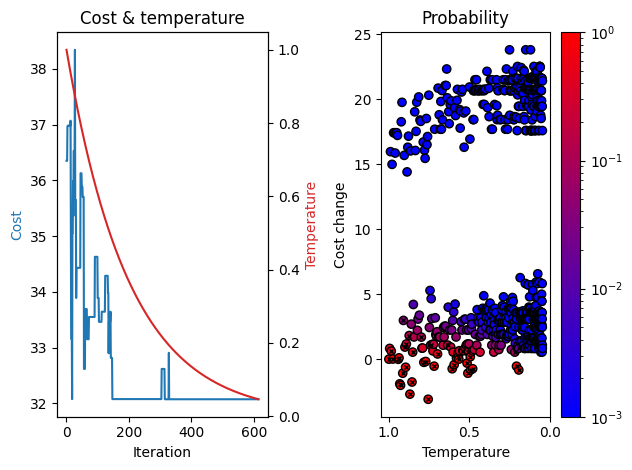

In [ ]:
optimizer.plot_solution()

In [ ]:
print("Creating optimal path")
full_path, distances = calculate_full_path(graph, optimal_route, coordinates)

Creating optimal path


In [ ]:
print("Creating map")
# create_map_ref(graph, path, route, dic, distances):
map = create_map_ref(graph = graph,
                     path=full_path,
                     dic = LOCATIONS)
map

Creating map


<ipython-input-97-4fb30b5931b9>:4: UserWarning: The `folium` module has been deprecated and will be removed in a future release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_map = ox.plot_route_folium(graph, path, tiles="OpenStreetMap", zoom_start=12)


## Roteiro Centro Historico

In [158]:
LOCATIONS = {
    "Beco da Lama" : (-5.785610336353063, -35.20699693914798),
    "Espaço Cultural Ruy Pereira": (-5.787766763067068, -35.207153537299014),
    "Igreja do Rosário dos Pretos - Mirante": (-5.782621945996149, -35.20667211877255),
    "Praça André de Albuquerque": (-5.785191803882805, -35.20866572565476),
    "Igreja Matriz Nossa Senhora da Apresentação": (-5.785436290745536, -35.20784687716768),
    "Memorial Câmara Cascudo": (-5.785682858917134, -35.20870695079232),
    "Igreja Bom Jesus das Dores": (-5.777371330439005, -35.203201458739),
    "Igreja Nossa Senhora de Lourdes": (-5.783987885445825, -35.19107845355456),
    "Solar Bela Vista": (-5.78206840919937, -35.20570733600112),
    "Instituto Histórico Geográfico do Rio Grande do Norte": (-5.785224887827328, -35.2079169396987),
    "Rua da Conceição": (-5.785796662250734, -35.208640345245676),
    "Museu Café Filho": (-5.785004284495744, -35.20862544044585),
    "Bar de Nazaré": (-5.785426107197823, -35.20814846928161),
    "Capitania das Artes": (-5.782051625921269, -35.2065878470947),
    "Museu de Cultura Popular Djalma Maranhão": (-5.779419162426871, -35.20523003360128),
    "Teatro Alberto Maranhão": (-5.779044873430843, -35.204774073530196),
    "Instituto Câmara Cascudo": (-5.781550206031478, -35.20558382990333)
}

USE_SAVED_DISTANCES = False

START_LOCATION = "Teatro Alberto Maranhão"
END_LOCATION = "Teatro Alberto Maranhão"


In [159]:
graph = graph_from_place('Natal, Rio Grande do Norte, Brazil', network_type='walk')

In [160]:
config(log_console=False, use_cache=True, cache_folder='./cache')
logging.basicConfig(level=logging.INFO)

<ipython-input-160-8036529aab0c>:1: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  config(log_console=False, use_cache=True, cache_folder='./cache')


In [161]:
loc_names, coordinates = [], []
for name, coord in LOCATIONS.items():
    loc_names.append(name)
    #coordinates.append(coord)
    coordinates.append((coord[1], coord[0]))

In [162]:
print(loc_names)

['Beco da Lama', 'Espaço Cultural Ruy Pereira', 'Igreja do Rosário dos Pretos - Mirante', 'Praça André de Albuquerque', 'Igreja Matriz Nossa Senhora da Apresentação', 'Memorial Câmara Cascudo', 'Igreja Bom Jesus das Dores', 'Igreja Nossa Senhora de Lourdes', 'Solar Bela Vista', 'Instituto Histórico Geográfico do Rio Grande do Norte', 'Rua da Conceição', 'Museu Café Filho', 'Bar de Nazaré', 'Capitania das Artes', 'Museu de Cultura Popular Djalma Maranhão', 'Teatro Alberto Maranhão', 'Instituto Câmara Cascudo']


In [163]:
print(coordinates)

[(-35.20699693914798, -5.785610336353063), (-35.207153537299014, -5.787766763067068), (-35.20667211877255, -5.782621945996149), (-35.20866572565476, -5.785191803882805), (-35.20784687716768, -5.785436290745536), (-35.20870695079232, -5.785682858917134), (-35.203201458739, -5.777371330439005), (-35.19107845355456, -5.783987885445825), (-35.20570733600112, -5.78206840919937), (-35.2079169396987, -5.785224887827328), (-35.208640345245676, -5.785796662250734), (-35.20862544044585, -5.785004284495744), (-35.20814846928161, -5.785426107197823), (-35.2065878470947, -5.782051625921269), (-35.20523003360128, -5.779419162426871), (-35.204774073530196, -5.779044873430843), (-35.20558382990333, -5.781550206031478)]


In [164]:
distances_matrix = None
if USE_SAVED_DISTANCES:
    print("Loading distances from file")
    try:
        distances_matrix = np.loadtxt("distances.txt")
    except OSError:
        USE_SAVED_DISTANCES = False
        print("Could not find distances.txt file.")

if not USE_SAVED_DISTANCES:
    print("Calculating distances between points")
    distances_matrix = calculate_distance_matrix(graph, coordinates)
    print("Saving distances to file")
    np.savetxt("distances.txt", distances_matrix)

Calculating distances between points
Saving distances to file


In [165]:
optimizer = SARouteOptimizer(model=Model(cost_matrix=distances_matrix),
                             max_iter=1000,
                             max_iter_without_improvement=500)

In [166]:
print("Calculating optimal order of locations")
init_route = create_init_route(loc_names.index(START_LOCATION),
                               loc_names.index(END_LOCATION),
                               distances_matrix.shape[0])

Calculating optimal order of locations


In [167]:
start_time = time.time()
optimal_route, total_distance = optimizer.run(init_route)
end_time = time.time()


duration_ms = 1000 * (end_time - start_time)
print(f"Solution took {duration_ms:0.0f} ms")
print(f"Total Distance: {total_distance}")

Solution took 29 ms
Total Distance: 8.864744


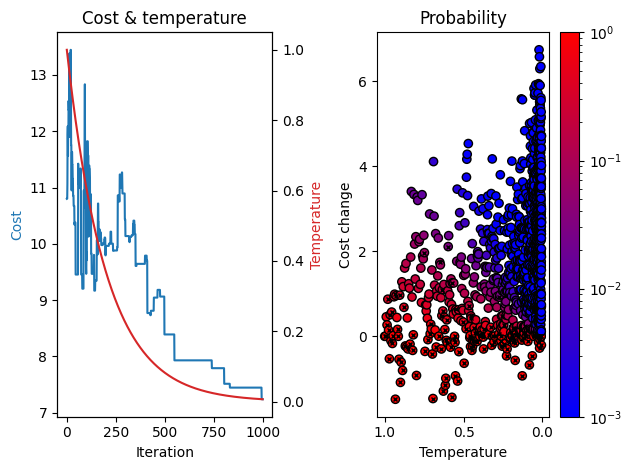

In [ ]:
optimizer.plot_solution()

In [ ]:
print("Creating optimal path")
full_path, distances = calculate_full_path(graph, optimal_route, coordinates)

Creating optimal path


In [ ]:
print("Creating map")
# create_map_ref(graph, path, route, dic, distances):
map = create_map_ref(graph = graph,
                     path=full_path,
                     dic = LOCATIONS)
map

Creating map


<ipython-input-97-4fb30b5931b9>:4: UserWarning: The `folium` module has been deprecated and will be removed in a future release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_map = ox.plot_route_folium(graph, path, tiles="OpenStreetMap", zoom_start=12)


# Informations about Natal's network

In [171]:
# Análise básica da rede
num_nodes = len(graph.nodes)
num_edges = len(graph.edges)
density = nx.density(graph)

In [172]:
# Saída dos resultados
print(f"Número de nós: {num_nodes}")
print(f"Número de arestas: {num_edges}")
print(f"Densidade da rede: {density}")

Número de nós: 18617
Número de arestas: 48453
Densidade da rede: 0.00013980561130955


In [133]:
# Medidas de centralidade
betweenness_centrality = nx.betweenness_centrality(graph)
closeness_centrality = nx.closeness_centrality(graph)

In [134]:
# Imprima as top 5 ruas mais importantes com base na centralidade de betweenness
print("\nTop 5 ruas importantes (Betweenness Centrality):")
for street, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{street}: {centrality}")



Top 5 ruas importantes (Betweenness Centrality):
8626911421: 0.26361706110482613
6415220871: 0.26051540324007083
530766064: 0.2600156233636526
5995875344: 0.260006622490502
582091628: 0.2551571112723133


In [135]:
# Imprima as top 5 interseções mais importantes com base na centralidade de closeness
print("\nTop 5 interseções importantes (Closeness Centrality):")
for intersection, centrality in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{intersection}: {centrality}")


Top 5 interseções importantes (Closeness Centrality):
503426496: 0.014749829354204812
503422501: 0.01474748162987429
503422500: 0.014743940863430102
502752848: 0.014709413055091504
503422531: 0.014685958741832792
